In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms

torch.manual_seed(111)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x) # logits, usually in output
        output = F.log_softmax(x, dim=1) # first compute softmax, then log
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    train_losses = []
    train_accuracies = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # remove to accumulate gradients (ex. with a batch too big for memory)

        output = model(data) # call to forward
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    print(f"Mean train loss, epoch {epoch}: {np.mean(train_losses):.3f}")
    return train_losses

In [ ]:
def test(model, device, test_loader):
    test_losses = []
    test_accuracies = []
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = F.nll_loss(output, target, reduction='sum').item()
            test_losses.append(test_loss)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item()
            test_accuracies.append(correct / len(data))
            total_correct += correct

    test_loss = np.mean(test_losses)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, total_correct, len(test_loader.dataset),
        100. * total_correct / len(test_loader.dataset)))

    return test_losses, test_accuracies

In [ ]:
device = torch.device("cuda") # to use the GPU
batch_size = 64
epochs = 5

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Changes with dataset, standard is ImageNet
      ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True, shuffle=True, batch_size=batch_size)

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), 0.1) # 0.1 is the learning rate

train_losses_epoch = []
train_losses_iter = []
test_losses_epoch = []
test_losses_iter = []
test_accuracies_epoch = []
test_accuracies_iter = []
for epoch in range(1, epochs + 1):
    train_losses = train(model, device, train_loader, optimizer, epoch)
    train_losses_iter += train_losses
    train_losses_epoch.append(np.mean(train_losses))
    test_losses, test_accuracies = test(model, device, test_loader)
    test_losses_iter += test_losses
    test_losses_epoch.append(np.mean(test_losses))
    test_accuracies_iter += test_accuracies
    test_accuracies_epoch.append(np.mean(test_accuracies))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.5MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 411kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.74MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296441
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.063985
Mean train loss, epoch 1: 0.173

Test set: Average loss: 3.7890, Accuracy: 9800/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034288
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.010974
Mean train loss, epoch 2: 0.044

Test set: Average loss: 2.4574, Accuracy: 9869/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019759
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.085451
Mean train loss, epoch 3: 0.027

Test set: Average loss: 2.5737, Accuracy: 9877/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.054082
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.011006
Mean train loss, epoch 4: 0.018

Test set: Average loss: 2.1252, Accuracy: 9901/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.013720
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001430
Mean train loss, epoch 5: 0.012

Test set: Average loss: 2.1411, Accuracy: 9

##Exercise 0
Create a plot of the values of the training/test losses and training accuracies/test.

This can help to monitor how the training is going.

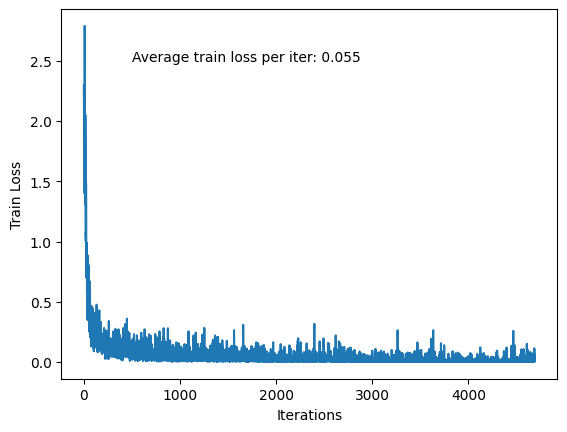

In [ ]:
import matplotlib.pyplot as plt

# Train loss plot with iterations
plt.text(x = 500, y = 2.5, s = f"Average train loss per iter: {round(np.mean(train_losses_iter), 3)}")
plt.plot(train_losses_iter)
plt.xlabel("Iterations")
plt.ylabel("Train Loss")
plt.show()


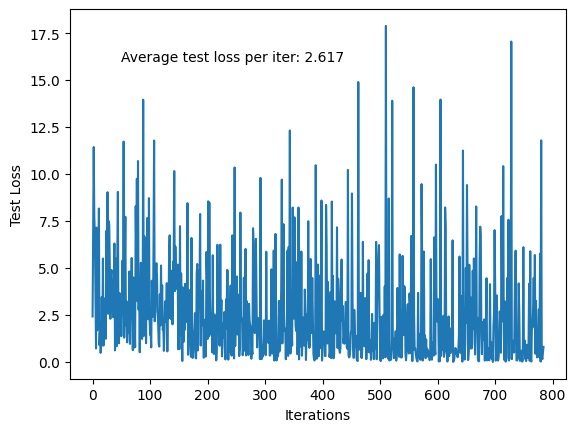

In [ ]:
# Test loss plot with iterations
plt.text(x = 50, y = 16, s = f"Average test loss per iter: {round(np.mean(test_losses_iter), 3)}")
plt.plot(test_losses_iter)
plt.xlabel("Iterations")
plt.ylabel("Test Loss")
plt.show()

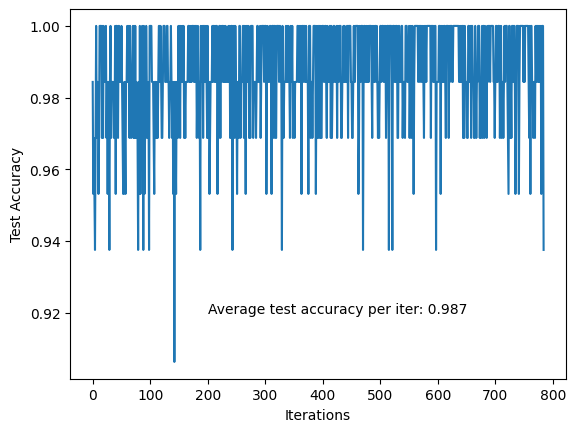

In [ ]:
# Test accuracies with iterations
plt.text(x = 200, y = 0.92, s = f"Average test accuracy per iter: {round(np.mean(test_accuracies_iter), 3)}")
plt.plot(test_accuracies_iter)
plt.xlabel("Iterations")
plt.ylabel("Test Accuracy")
plt.show()

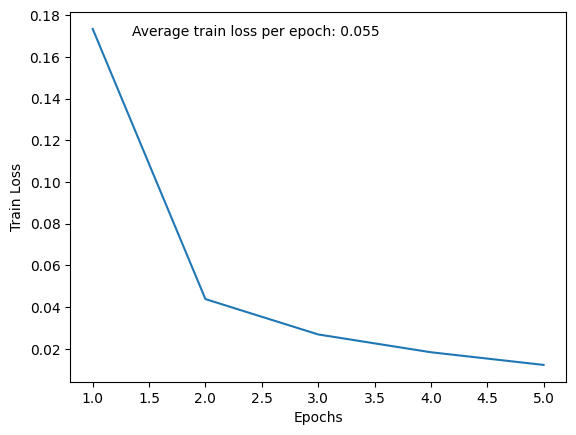

In [ ]:
# Train losses plot with epochs
epochs = [i + 1 for i in range(5)]
plt.text(x = 1.35, y = 0.17, s = f"Average train loss per epoch: {round(np.mean(train_losses_epoch), 3)}")
plt.plot(epochs, train_losses_epoch)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.show()

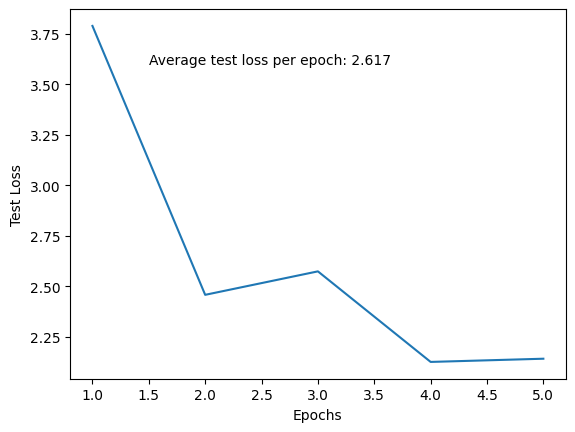

In [ ]:
# Test losses plot with epochs
plt.text(x = 1.5, y = 3.6, s = f"Average test loss per epoch: {round(np.mean(test_losses_epoch), 3)}")
plt.plot(epochs, test_losses_epoch)
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.show()

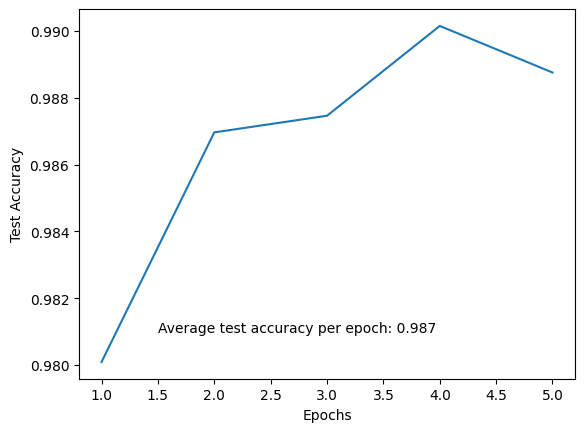

In [ ]:
# Test accuracies with epochs
plt.text(x = 1.5, y = 0.981, s = f"Average test accuracy per epoch: {round(np.mean(test_accuracies_epoch), 3)}")
plt.plot(epochs, test_accuracies_epoch)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

## Exercise 1

Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding)

How the performance change? Why?

In [ ]:
# Network with all linear layers
class FC_Net(nn.Module):
    def __init__(self, input_size = 784, output_size = 10, layers = [32, 32]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, layers[0])
        self.inner_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.last_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.first_layer(x))
        for layer in self.inner_layers:
            x = F.relu(layer(x))
        x = self.last_layer(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
def get_results(model):
    device = torch.device("cuda") # to use the GPU
    batch_size = 64
    epochs = 5

    model.to(device)

    optimizer = optim.SGD(model.parameters(), 0.1) # 0.1 is the learning rate

    train_losses_epoch = []
    train_losses_iter = []
    test_losses_epoch = []
    test_losses_iter = []
    test_accuracies_epoch = []
    test_accuracies_iter = []
    for epoch in range(1, epochs + 1):
        train_losses = train(model, device, train_loader, optimizer, epoch)
        train_losses_iter += train_losses
        train_losses_epoch.append(np.mean(train_losses))
        test_losses, test_accuracies = test(model, device, test_loader)
        test_losses_iter += test_losses
        test_losses_epoch.append(np.mean(test_losses))
        test_accuracies_iter += test_accuracies
        test_accuracies_epoch.append(np.mean(test_accuracies))

    return train_losses_epoch, train_losses_iter, test_losses_epoch, test_losses_iter, test_accuracies_epoch, test_accuracies_iter

In [ ]:
model1 = FC_Net(layers = [32, 64 ,128])
model2 = FC_Net(layers = [20384, 20384]) # few large layers -> overfitting, too much parameters
model3 = FC_Net(layers = [32, 32, 32, 32, 32, 32, 32, 32, 32]) # vanishing gradient

_, _, _, _, test_accuracies_epoch1, _ = get_results(model1)
_, _, _, _, test_accuracies_epoch2, _ = get_results(model2) # Too big for colab, not enough memory
_, _, _, _, test_accuracies_epoch3, _ = get_results(model3)

print(f"Test accuracies with layers [32, 64, 128]: {test_accuracies_epoch1}")
print(f"Test accuracies with layers [512, 2014]: {test_accuracies_epoch2}")
print(f"Test accuracies with layers [32, 64, 128, 64, 32]: {test_accuracies_epoch3}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298834
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.288225
Mean train loss, epoch 1: 0.376

Test set: Average loss: 13.3611, Accuracy: 9370/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.279196
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.045198
Mean train loss, epoch 2: 0.155

Test set: Average loss: 8.5678, Accuracy: 9584/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.112220
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.062490
Mean train loss, epoch 3: 0.116

Test set: Average loss: 7.3431, Accuracy: 9650/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.125882
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.041088
Mean train loss, epoch 4: 0.096

Test set: Average loss: 6.5468, Accuracy: 9691/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.121181
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.136500
Mean train loss, epoch 5: 0.084

Test set: Average loss: 5.8805, Accuracy: 9713/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309520
Train Epoch: 1

In [ ]:
# Changing hyperparameters of the model with conv layers
# Only one parameter will be changed, the other ones will remain the same as the initial model, for better comparison
class Net(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=0):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, stride, padding)
        if kernel_size == 3 and stride == 1:
            self.fc1 = nn.Linear(9216, 128)
        elif kernel_size == 5 and padding == 0:
            self.fc1 = nn.Linear(6400, 128)
        elif kernel_size == 7 and padding == 0:
            self.fc1 = nn.Linear(4096, 128)
        elif stride == 2:
            self.fc1 = nn.Linear(576, 128)
        elif stride == 3:
            self.fc1 = nn.Linear(64, 128)
        else: # kernel_size == 1
            self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x) # logits, usually in output
        output = F.log_softmax(x, dim=1) # first compute softmax, then log
        return output

In [ ]:
# Changing kernel dimension of the conv layers
model1 = Net(kernel_size=5)
model2 = Net(kernel_size=1)
model3 = Net(kernel_size=7)

_, _, _, _, test_accuracies_epoch1, _ = get_results(model1)
_, _, _, _, test_accuracies_epoch2, _ = get_results(model2)
_, _, _, _, test_accuracies_epoch3, _ = get_results(model3)

print(f"Test accuracies with kernel size 5: {test_accuracies_epoch1}")
print(f"Test accuracies with kernel size 1: {test_accuracies_epoch2}")
print(f"Test accuracies with kernel size 7: {test_accuracies_epoch3}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316701
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.106564
Mean train loss, epoch 1: 0.145

Test set: Average loss: 3.0832, Accuracy: 9833/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.037462
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.090116
Mean train loss, epoch 2: 0.040

Test set: Average loss: 2.0131, Accuracy: 9887/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.020724
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.008018
Mean train loss, epoch 3: 0.026

Test set: Average loss: 1.9962, Accuracy: 9887/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.031316
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.028825
Mean train loss, epoch 4: 0.019

Test set: Average loss: 1.5160, Accuracy: 9924/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.002256
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.208145
Mean train loss, epoch 5: 0.013

Test set: Average loss: 1.9408, Accuracy: 9909/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296011
Train Epoch: 1 

In [ ]:
# Changing padding of the conv layers, based on the previous models
model1 = Net(kernel_size=5, padding=2)
model2 = Net(kernel_size=7, padding=3)

_, _, _, _, test_accuracies_epoch1, _ = get_results(model1)
_, _, _, _, test_accuracies_epoch2, _ = get_results(model2)

print(f"Test accuracies with kernel size 5 and padding 2: {test_accuracies_epoch1}")
print(f"Test accuracies with kernel size 7 and padding 3: {test_accuracies_epoch2}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303621
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.125818
Mean train loss, epoch 1: 0.157

Test set: Average loss: 2.8322, Accuracy: 9847/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042633
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.008103
Mean train loss, epoch 2: 0.041

Test set: Average loss: 2.4184, Accuracy: 9879/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007294
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.036071
Mean train loss, epoch 3: 0.026

Test set: Average loss: 2.9742, Accuracy: 9835/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.034356
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.006952
Mean train loss, epoch 4: 0.019

Test set: Average loss: 2.2398, Accuracy: 9880/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.014032
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.004938
Mean train loss, epoch 5: 0.014

Test set: Average loss: 1.6928, Accuracy: 9920/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312717
Train Epoch: 1 

In [ ]:
# Changing stride of the conv layers
model1 = Net(stride=2)
model2 = Net(stride=3) # output is 64x64, no need to reduce further

_, _, _, _, test_accuracies_epoch1, _ = get_results(model1)
_, _, _, _, test_accuracies_epoch2, _ = get_results(model2)

print(f"Test accuracies with stride 2: {test_accuracies_epoch1}")
print(f"Test accuracies with stride 3: {test_accuracies_epoch2}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297785
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.108795
Mean train loss, epoch 1: 0.300

Test set: Average loss: 6.7331, Accuracy: 9654/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.036804
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.167452
Mean train loss, epoch 2: 0.080

Test set: Average loss: 3.4991, Accuracy: 9818/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.026911
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.061209
Mean train loss, epoch 3: 0.056

Test set: Average loss: 3.4028, Accuracy: 9819/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.069808
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.029500
Mean train loss, epoch 4: 0.043

Test set: Average loss: 2.5720, Accuracy: 9861/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010698
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.022059
Mean train loss, epoch 5: 0.033

Test set: Average loss: 2.4305, Accuracy: 9873/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324431
Train Epoch: 1 

## Exercise 2

Try to work with the hyperparameters (batch_size, learning_rate, ...).

In particular try to focus on the optimization part. Change algorithm, momentum, parameters...

Please refer to https://pytorch.org/docs/stable/optim.html to see how to set all the parameters

How can it be improved?

In [ ]:
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    train_losses = []
    train_accuracies = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # remove to accumulate gradients (ex. with a batch too big for memory)

        output = model(data) # call to forward
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    if scheduler is not None:
        scheduler.step()

    print(f"Mean train loss, epoch {epoch}: {np.mean(train_losses):.3f}")
    return train_losses

def get_results(lr, momentum=0, optimizer='SGD', scheduler=None):
    device = torch.device("cuda") # to use the GPU
    batch_size = 64
    epochs = 5

    model = Net().to(device)

    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr, momentum)
    elif optimizer == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr)

    train_losses_epoch = []
    train_losses_iter = []
    test_losses_epoch = []
    test_losses_iter = []
    test_accuracies_epoch = []
    test_accuracies_iter = []
    for epoch in range(1, epochs + 1):
        train_losses = train(model, device, train_loader, optimizer, epoch, scheduler)
        train_losses_iter += train_losses
        train_losses_epoch.append(np.mean(train_losses))
        test_losses, test_accuracies = test(model, device, test_loader)
        test_losses_iter += test_losses
        test_losses_epoch.append(np.mean(test_losses))
        test_accuracies_iter += test_accuracies
        test_accuracies_epoch.append(np.mean(test_accuracies))

    return train_losses_epoch, train_losses_iter, test_losses_epoch, test_losses_iter, test_accuracies_epoch, test_accuracies_iter

In [ ]:
# Changing learning rate of SGD
_, _, _, _, test_accuracies_epoch1, _ = get_results(lr=0.01, optimizer='SGD') # lower learning rate

_, _, _, _, test_accuracies_epoch2, _ = get_results(lr=0.03, optimizer='SGD') # lower learning rate

_, _, _, _, test_accuracies_epoch3, _ = get_results(lr=0.5, optimizer='SGD') # higher learning rate

print(f"Test accuracies with learning rate 0.01 and SGD: {test_accuracies_epoch1}")
print(f"Test accuracies with learning rate 0.03 and SGD: {test_accuracies_epoch2}")
print(f"Test accuracies with learning rate 0.5 and SGD: {test_accuracies_epoch3}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313278
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.210851
Mean train loss, epoch 1: 0.453

Test set: Average loss: 12.0566, Accuracy: 9433/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.188196
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.068304
Mean train loss, epoch 2: 0.156

Test set: Average loss: 8.4620, Accuracy: 9599/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.094205
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.036667
Mean train loss, epoch 3: 0.105

Test set: Average loss: 5.3008, Accuracy: 9736/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.063301
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.032948
Mean train loss, epoch 4: 0.077

Test set: Average loss: 4.7108, Accuracy: 9773/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.127348
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.068912
Mean train loss, epoch 5: 0.061

Test set: Average loss: 4.0232, Accuracy: 9793/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304904
Train Epoch: 1

In [ ]:
# Changing momentum of SGD
_, _, _, _, test_accuracies_epoch1, _ = get_results(lr=0.01, momentum=0.9, optimizer='SGD') # More importance to gradient history

_, _, _, _, test_accuracies_epoch2, _ = get_results(lr=0.01, momentum=0.5, optimizer='SGD') # Equal

_, _, _, _, test_accuracies_epoch3, _ = get_results(lr=0.01, momentum=0.1, optimizer='SGD') # Less importance to gradient history

print(f"Test accuracies with learning rate 0.01, momentum 0.9 and SGD: {test_accuracies_epoch1}")
print(f"Test accuracies with learning rate 0.01, momentum 0.5 and SGD: {test_accuracies_epoch2}")
print(f"Test accuracies with learning rate 0.01, momentum 0.1 and SGD: {test_accuracies_epoch3}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299963
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.088990
Mean train loss, epoch 1: 0.179

Test set: Average loss: 3.0361, Accuracy: 9854/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.035626
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.067890
Mean train loss, epoch 2: 0.046

Test set: Average loss: 2.5221, Accuracy: 9861/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.053393
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.029631
Mean train loss, epoch 3: 0.029

Test set: Average loss: 2.2398, Accuracy: 9884/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.010846
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002243
Mean train loss, epoch 4: 0.020

Test set: Average loss: 1.9982, Accuracy: 9904/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000465
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.006120
Mean train loss, epoch 5: 0.013

Test set: Average loss: 2.0865, Accuracy: 9900/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301148
Train Epoch: 1 

In [ ]:
# With Adam
_, _, _, _, test_accuracies_epoch1, _ = get_results(lr=0.0001, optimizer='ADAM') # lower learning rate

_, _, _, _, test_accuracies_epoch2, _ = get_results(lr=0.0003, optimizer='ADAM') # lower learning rate

_, _, _, _, test_accuracies_epoch3, _ = get_results(lr=0.01, optimizer='ADAM') # higher learning rate

print(f"Test accuracies with learning rate 0.0001 and ADAM: {test_accuracies_epoch1}")
print(f"Test accuracies with learning rate 0.0003 and ADAM: {test_accuracies_epoch2}")
print(f"Test accuracies with learning rate 0.01 and ADAM: {test_accuracies_epoch3}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300649
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.313705
Mean train loss, epoch 1: 0.290

Test set: Average loss: 5.6764, Accuracy: 9737/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.157394
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.112499
Mean train loss, epoch 2: 0.078

Test set: Average loss: 3.7294, Accuracy: 9815/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.027616
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.056645
Mean train loss, epoch 3: 0.051

Test set: Average loss: 2.7285, Accuracy: 9861/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019000
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.052177
Mean train loss, epoch 4: 0.039

Test set: Average loss: 2.3679, Accuracy: 9864/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011128
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.012781
Mean train loss, epoch 5: 0.031

Test set: Average loss: 2.4142, Accuracy: 9872/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306376
Train Epoch: 1 